In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from algorithms import *

### run on actual historical ordering (Table 1)

In [2]:
reports = pd.read_csv('data_processed/vaers/covid__reports.csv')
group_dicts = pickle.load(open('data_processed/vaers/covid__groups.pkl', 'rb'))
base_rates = pickle.load(open('data_processed/vaers/covid__base_groups.pkl', 'rb'))

In [5]:
all_algorithms = \
[
    { 'name': 'Betting-style test', 'params': {'method': 'eval'}},
    { 'name': 'Finite-sample Z-test', 'params': {'method': 'lil', 'asymptotic': False}},
    { 'name': 'Asymptotic Z-test', 'params': {'method': 'lil', 'asymptotic': True}}
] 

result_df = pd.DataFrame(columns=['alg', 'beta', 't'])
for alg in all_algorithms:
    for beta in [2, 2.5, 3]:
        res = run_test(reports, group_dicts, base_rates, ALPHA=0.1, BETA=beta, **alg['params'])
        res['alg'] = alg['name']
        res['beta'] = beta
        result_df = pd.concat([result_df, res])


/home/eecs/jessicadai/incidents/algorithms.py:196: RuntimeWarning: invalid value encountered in sqrt
  thresh_factor = np.sqrt(mu*(1-mu)) if self.asymp else 0.5
/home/eecs/jessicadai/incidents/algorithms.py:196: RuntimeWarning: invalid value encountered in sqrt
  thresh_factor = np.sqrt(mu*(1-mu)) if self.asymp else 0.5
/home/eecs/jessicadai/incidents/algorithms.py:196: RuntimeWarning: invalid value encountered in sqrt
  thresh_factor = np.sqrt(mu*(1-mu)) if self.asymp else 0.5


In [6]:
result_df

,alg,beta,t,group,t-inv
0,Betting-style test,2,61,7.0,17.0
1,Betting-style test,2,103,21.0,49.0
2,Betting-style test,2,241,13.0,187.0
3,Betting-style test,2,308,24.0,198.0
0,Betting-style test,2.5,69,7.0,47.0
1,Betting-style test,2.5,132,21.0,116.0
2,Betting-style test,2.5,259,13.0,193.0
3,Betting-style test,2.5,341,24.0,256.0
0,Betting-style test,3,80,7.0,49.0
1,Betting-style test,3,302,13.0,198.0


### Plots

In [2]:
all_res = pd.DataFrame(columns=['beta', 'trial', 'alg', 'group', 't', 't-inv'])

for beta in [1.01, 1.5, 2.0, 2.5, 3.0]:
    res = pd.read_csv(f'results/covid_ntrials=100_beta={str(beta)}_alphas=0.1.csv')
    res['beta'] = beta
    all_res = pd.concat([all_res, res])
all_first_rejections = pd.DataFrame()
for beta in all_res['beta'].unique():
    res = all_res[all_res['beta'] == beta]
    for i in range(100):
        for alg in res['alg'].unique():
            rejections = res[(res['alg'] == alg) & (res['trial'] == i)]
            if len(rejections) > 0:
                firstrej = rejections.iloc[rejections['t'].argmin()]
                t = firstrej['t']
                group = firstrej['group']
                firstrej_inv = rejections.iloc[rejections['t-inv'].argmin()]
                inv = firstrej_inv['t-inv']
                group_inv = firstrej_inv['group']
                all_first_rejections = pd.concat([all_first_rejections, pd.DataFrame({'beta': [beta], 'trial': [i], 'alg': [alg], 'group': [group], 't': [t], 't-inv': [inv], 'group-inv': group_inv})])

/tmp/ipykernel_2571266/1591926345.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_res = pd.concat([all_res, res])


In [3]:
BETA = 2

In [4]:
curr_plot = all_first_rejections[(all_first_rejections['beta'] == BETA) & (all_first_rejections['alg'] != 'sprt')]
new = curr_plot.groupby(['alg', 'trial']).min()[['t', 't-inv', 'group', 'group-inv']].reset_index()
full = pd.DataFrame()
for alg in ['eval', 'lila', 'lilt']:
    curr = new[new['alg'] == alg]
    t_sorted = curr.sort_values('t')[['t', 'group']]
    t_inv_sorted = curr.sort_values('t-inv')[['t-inv', 'group-inv']]
    order = np.arange(100)
    full = pd.concat([full, pd.DataFrame({'t': t_sorted['t'].values, 't_g': t_sorted['group'].values, 't-inv': t_inv_sorted['t-inv'], 't-inv_g': t_inv_sorted['group-inv'], 'order': order, 'alg': alg})])

#### Figure 1

Text(0, 0, 'eval')
Text(0, 0, 'lila')
Text(0, 0, 'lilt')


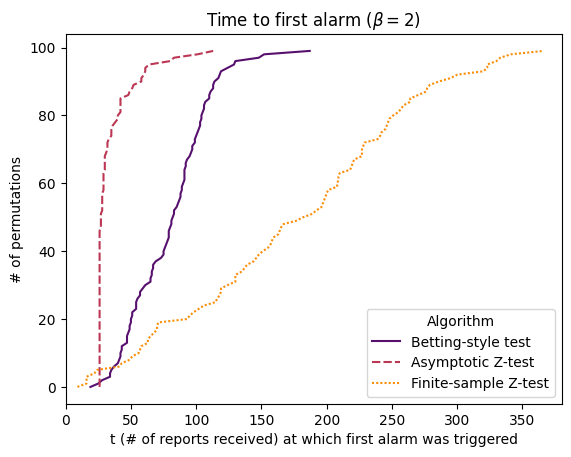

In [10]:
g = sns.lineplot(data=full, x='t', y='order', palette='inferno', style='alg', hue='alg', estimator=None) #, ci=None)
g.legend_.set_title('Algorithm')
new_labels = ['Betting-style test' , 'Asymptotic Z-test', 'Finite-sample Z-test']
for t, l in zip(g.legend_.texts, new_labels): 
    print(t)
    t.set_text(l)
g.set(xlabel='t (# of reports received) at which first alarm was triggered', ylabel='# of permutations', title=rf'Time to first alarm ($\beta= {BETA}$)', xlim=(0,380))# ($\beta$ = {BETA})')
plt.show(g)


#### Figure 2

In [16]:
i = 13
bonf_delta = int(np.log(29)/(get_group_report_rate(reports, group_dicts[i]) - base_rates[i]*2)**2)

In [5]:
curr_alg = full[full['alg'] == 'eval']

/tmp/ipykernel_2571266/4044251657.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.lineplot(x = curr_alg['t-inv'], y=curr_alg['order'], ci=None, label='Invalid (no Bonferroni)', estimator=None, color='xkcd:dusty lavender', linestyle='--')
/tmp/ipykernel_2571266/4044251657.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.lineplot(x = curr_alg['t'], y=curr_alg['order'], ci=None, label='Valid (with Bonferroni)', estimator=None, linestyle='-', color='xkcd:ugly purple')


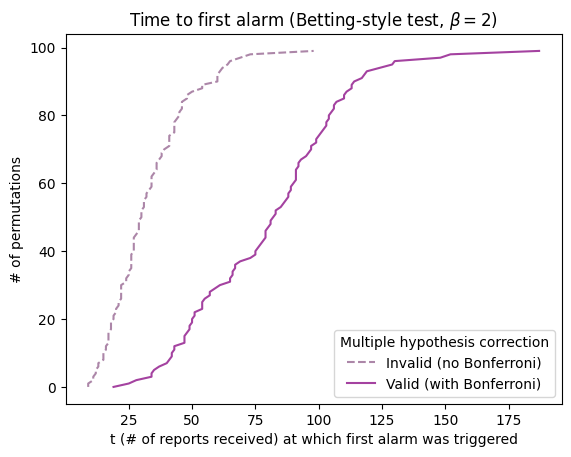

In [6]:
g = sns.lineplot(x = curr_alg['t-inv'], y=curr_alg['order'], ci=None, label='Invalid (no Bonferroni)', estimator=None, color='xkcd:dusty lavender', linestyle='--')
g = sns.lineplot(x = curr_alg['t'], y=curr_alg['order'], ci=None, label='Valid (with Bonferroni)', estimator=None, linestyle='-', color='xkcd:ugly purple')
# g = sns.lineplot(x = curr_alg['t-inv'] + bonf_delta, y=curr_alg['order'], ci=None, label='Thm. 4.4 upper bound', estimator=None, linestyle=':', color='xkcd:pale violet')
g.legend_.set_title('Multiple hypothesis correction')
g.legend_.set_loc('lower right')
g.set(xlabel='t (# of reports received) at which first alarm was triggered', ylabel='# of permutations', title=rf'Time to first alarm (Betting-style test, $\beta={BETA}$)') #, xlim=(0,380))
plt.show(g)
